In [ ]:
%load_ext sql
%sql sqlite://
%config SqlMagic.style = '_DEPRECATED_DEFAULT'

## Продолжаем работу с таблицами

In [ ]:
%%sql

DROP TABLE IF EXISTS Employees;

PRAGMA foreign_keys = OFF;

CREATE TABLE Employees(
    id int PRIMARY KEY,
    name varchar(20) NOT NULL,
    phone varchar(20),
    title varchar(20) NOT NULL,
    manager_id integer,
    FOREIGN KEY (manager_id) REFERENCES Employees(id)
);

In [ ]:
%%sql

--INSERT INTO Employees values  (1, 'Vasyugin', '+111', 'Director', NULL);
INSERT INTO Employees values  (2, 'Jones', '+112', 'Vice President', 1);
INSERT INTO Employees values  (3, 'Smith', '+113', 'Vice President', 1);
INSERT INTO Employees values (4, 'Velaskes', '+114', 'Developer', 2);
INSERT INTO Employees values (5, 'Simon', '+115', 'Analyst', 2);
INSERT INTO Employees values (6, 'Johnson', '+116', 'Engineer', 3);
INSERT INTO Employees values (7, 'Lee', '+117', 'Engineer', 3);

In [ ]:
%%sql

PRAGMA foreign_key_check; -- проверка целостности

In [ ]:
%%sql

PRAGMA foreign_keys = ON;

In [ ]:
%%sql
DROP TABLE IF EXISTS Students;
DROP TABLE IF EXISTS Faculties;

CREATE TABLE Faculties(
    id integer PRIMARY KEY,
    name varchar(50) NOT NULL,
    UNIQUE (name) -- уникальные значения
);

CREATE TABLE Students(
    id integer PRIMARY KEY,
    name varchar(50) NOT NULL,
    gpa decimal(2,2),
    faculty_id integer,
    FOREIGN KEY (faculty_id) REFERENCES Faculties(id)
);

In [ ]:
%%sql
INSERT INTO Faculties values (1, 'IT');
INSERT INTO Faculties values (2, 'KIB');

INSERT INTO Students values (1, 'Sidorov', 3.0, 1);
INSERT INTO Students values (2, 'Petrov', 3.5, 2);
INSERT INTO Students values (3, 'Verikov', 4.0, 1);
INSERT INTO Students values (4, 'Smith', 4.2, 2);
INSERT INTO Students values (5, 'Lee', 4.5, 1);
INSERT INTO Students values (6, 'Vorontsov', 3.2, NULL);

INSERT INTO Employees values  (1, 'Vasyugin', '+111', 'Director', NULL);
INSERT INTO Employees values  (2, 'Jones', '+112', 'Vice President', 1);
INSERT INTO Employees values  (3, 'Smith', '+113', 'Vice President', 1);
INSERT INTO Employees values (4, 'Velaskes', '+114', 'Developer', 2);
INSERT INTO Employees values (5, 'Simon', '+115', 'Analyst', 2);
INSERT INTO Employees values (6, 'Johnson', '+116', 'Engineer', 3);
INSERT INTO Employees values (7, 'Lee', '+117', 'Engineer', 3);

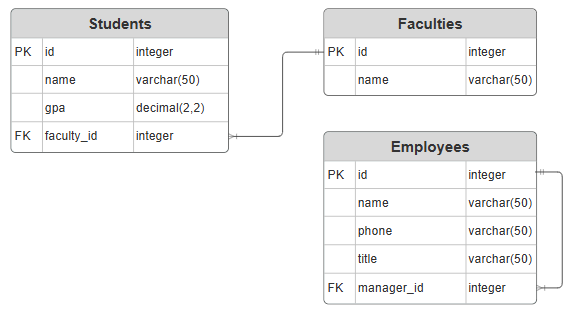

## Оператор WITH

In [ ]:
%%sql
WITH g AS
(
SELECT faculty_id, min(gpa) as min_gpa
    FROM Students
 GROUP
    BY faculty_id
)
SELECT s.*
    FROM Students s
INNER JOIN g
    ON s.faculty_id = g.faculty_id
WHERE s.gpa > g.min_gpa;

In [ ]:
%%sql
SELECT * FROM g;

In [ ]:
%%sql
WITH KIB_fac_id AS
(
SELECT id
    FROM Faculties
WHERE name = 'KIB'
),
min_gpa as
(
SELECT MIN(gpa) as min_gpa
    FROM Students
WHERE faculty_id = (SELECT id FROM KIB_fac_id)
)
SELECT *
    FROM Students
WHERE gpa > (SELECT min_gpa from min_gpa);

## Представления VIEW

In [ ]:
%%sql
CREATE VIEW IF NOT EXISTS StudentsAndFaculties AS
SELECT s.*, f.name as faculty_name
    FROM Students s
LEFT OUTER JOIN Faculties F
    ON s.faculty_id = f.id;

Представления — виртуальные таблицы, которые содержат запросы, динамически извлекающие используемые данные.

In [ ]:
%%sql
SELECT * FROM StudentsAndFaculties;

In [ ]:
%%sql

PRAGMA foreign_keys = OFF;
DROP TABLE Faculties;

In [ ]:
%%sql
SELECT * FROM StudentsAndFaculties;

## CASE WHEN

In [ ]:
%%sql
SELECT *,
    CASE WHEN gpa > 4.0
              THEN 'A'
            WHEN gpa > 3.0
              THEN 'B'
            ELSE 'C'
    END as mark
    FROM Students;

In [ ]:
%%sql
SELECT CASE WHEN gpa > 4.0
              THEN 'A'
            WHEN gpa > 3.0
              THEN 'B'
            ELSE 'C'
       END as mark,
       count(*) as cnt
    FROM Students
GROUP BY CASE WHEN gpa > 4.0
              THEN 'A'
            WHEN gpa > 3.0
              THEN 'B'
            ELSE 'C'
       END;

In [ ]:
%%sql
SELECT mark, count(*) FROM
    (SELECT CASE WHEN gpa > 4.0
                  THEN 'A'
                WHEN gpa > 3.0
                  THEN 'B'
                ELSE 'C'
          END as mark
        FROM Students) as c
GROUP BY c.mark;

## Рекурсивные запросы

In [ ]:
%%sql
WITH RECURSIVE cnt(x) AS (
    VALUES(1)

    UNION ALL

    SELECT x+1 FROM cnt
    WHERE x < 10
    )
SELECT x FROM cnt;

In [ ]:
%%sql
select * from Employees

In [ ]:
%%sql
WITH recursive ManagerPath(title_path, manager_id) AS (
    SELECT title as title_path, id as manager_id
        FROM Employees
    WHERE manager_id is null

    UNION

    SELECT ManagerPath.title_path || '->' || Employees.title as title_path, id as manager_id
        FROM ManagerPath
    INNER JOIN Employees
    ON ManagerPath.manager_id = Employees.manager_id
    )
select *
from ManagerPath

In [ ]:
%%sql
WITH recursive ManagerPath(title_path, manager_id, level) AS (
    SELECT title as title_path, id as manager_id, 1 as level
        FROM Employees
    WHERE manager_id is null

    UNION

    SELECT ManagerPath.title_path || '->' || Employees.title as title_path,
          id as manager_id,
          ManagerPath.level + 1 as level
    FROM ManagerPath
    INNER JOIN Employees using (manager_id)
)
select * from ManagerPath

In [ ]:
%%sql
WITH RECURSIVE cnt(x) AS (
    VALUES(1)

    UNION ALL

    SELECT x+1 FROM cnt
    WHERE x < 5
    --WHERE x > 0  -- бесконечная рекурсия (работать не будет)
    )
SELECT x FROM cnt;

## Ограничение целостности CHECK

In [ ]:
%%sql
DROP TABLE IF EXISTS Clients;

CREATE TABLE Clients(
    ID integer PRIMARY KEY,
    FirstName varchar(255) NOT NULL,
    LastName varchar(255) NOT NULL,
    Age integer,
    CHECK (Age>=18)
);

In [ ]:
%%sql
INSERT INTO Clients (FirstName, LastName, Age) VALUES ("Антон", "Иванов", 23);
INSERT INTO Clients (FirstName, LastName, Age) VALUES ("Андрей", "Степанов", 27);
INSERT INTO Clients (FirstName, LastName, Age) VALUES ("Наталья", "Ештукова", 20);
INSERT INTO Clients (FirstName, LastName, Age) VALUES ("Виктория", "Андреева", 37);
INSERT INTO Clients (FirstName, LastName, Age) VALUES ("Илья", "Ильин", 47);

In [ ]:
%%sql
SELECT * FROM Clients;

In [ ]:
%%sql
INSERT INTO Clients (FirstName, LastName, Age) VALUES ("Иван", "Воронцов", 17);

In [ ]:
%%sql
INSERT INTO Clients (FirstName, LastName) VALUES ("Иван", "Воронцов");

In [ ]:
%%sql
SELECT * FROM Clients;

## Функции работы со строками

https://www.sqlite.org/lang_corefunc.html

The default built-in lower()/upper() function works for ASCII characters only.

In [ ]:
%%sql
SELECT *, length(phone), LOWER(title), upper(name), replace(phone,'+','+7927') FROM Employees;

In [ ]:
%%sql
SELECT *, LOWER(FirstName) FROM Clients;

In [ ]:
%%sql
SELECT *, substring(title,2), substring(name,2,5), instr(name,"e"), instr(name,"on") FROM Employees;

## Работа с временем

https://www.sqlite.org/lang_datefunc.html

In [ ]:
%%sql
SELECT date('now'), time('now');

In [ ]:
%%sql
SELECT datetime('now', 'localtime');

In [ ]:
%%sql
SELECT timediff(datetime('now'), "2000-01-01");

In [ ]:
%%sql
SELECT julianday(datetime('now'));

In [ ]:
%%sql
SELECT julianday(datetime('now')) - julianday(datetime("2000-01-01")) as diff;

In [ ]:
%%sql
SELECT datetime('now', 'start of day'), date('now','start of month'), date('now','weekday 4');

In [ ]:
%%sql
SELECT datetime('now', '+3 hours');

In [ ]:
%%sql
SELECT datetime('now', '+3 hours');

In [ ]:
%%sql
SELECT datetime('now','start of month','+1 month','-1 day'); --last day of the current month

In [ ]:
%%sql
SELECT julianday(datetime('now', 'start of day')) - julianday(datetime("2000-01-01")) as diff;

In [ ]:
%%sql
SELECT 1
WHERE "2025-10-22" == date('now');

### strftime()

In [ ]:
%%sql
SELECT strftime('%d', datetime('now'));

In [ ]:
%%sql
SELECT strftime('%d-%m-%Y, time: %H:%M:%S', datetime('now'));

In [ ]:
%%sql
SELECT 1
WHERE strftime('%Y', datetime('now')) == "2025";

## Математические функции

In [ ]:
%%sql
DROP TABLE IF EXISTS Numbers;

CREATE TABLE Numbers(
    a integer,
    b integer
);

In [ ]:
%%sql
INSERT INTO Numbers VALUES ("2025-01-01"); --между -9223372036854775808 и +9223372036854775807
INSERT INTO Numbers VALUES (random(), 0);
INSERT INTO Numbers VALUES (random(), 0);
SELECT * FROM Numbers;

In [ ]:
%%sql
INSERT INTO Numbers VALUES (abs(random() % 10), abs(random() % 10)); --между 0 and 10
INSERT INTO Numbers VALUES ((abs(random()) % (10-1)+1), (abs(random()) % (10-1)+1)); --между 1 and 10
INSERT INTO Numbers VALUES (NULL, NULL);
SELECT * FROM Numbers;

In [ ]:
%%sql
SELECT a, b, ROUND(sin(a),3), cos(a), atan(a), ROUND(sqrt(a)), ln(a), pow(a,b) FROM Numbers;